pytorch alexnet_transfer_learning synthetic_data normalization feature_extractor \
classifier=[fc1,fc2,fc3]; all fc HE initialized; classifier trained then fine tuned with all model train as a whole.

# Transfer Learning for OxfordIIITPet Data using AlexNet

**Author**: [zoraiz](https://github.com/ramayzoraiz)


-   **ConvNet as fixed feature extractor**: Here, we will freeze the
    weights for all of the network except that of the final fully
    connected layer. This last fully connected layer is replaced with a
    new one with random weights and only this layer is trained.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
from torchinfo import summary
from pytorch_utils import load_simple_data, data_augment, normalize_data

# Set random seed for reproducibility
torch.manual_seed(42)
cudnn.benchmark = True
# cudnn.deterministic = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Hyperparameters

In [2]:
BATCH_SIZE = 256
IMAGE_SIZE = 128

## Load Data

In [3]:
train_ds, val_ds = load_simple_data()

In [4]:
class_names = train_ds.datasets[0].classes
NUM_CLASSES = len(class_names)
print(f"Number of classes: {NUM_CLASSES}")
print(f"Number of training samples: {len(train_ds)}")
print(f"Number of validation samples: {len(val_ds)}")

Number of classes: 37
Number of training samples: 6248
Number of validation samples: 1101


## Preprocess/Synthesize dataset

In [5]:
train_ds, val_ds = data_augment(train_ds, val_ds)

In [6]:
print(f"Number of training samples after augmentartion: {len(train_ds)}")
print(f"Number of original validation samples after augmentation: {len(val_ds)}")

Number of training samples after augmentartion: 37488
Number of original validation samples after augmentation: 1101


## Calculating Normalization

In [7]:
# # Calculate the mean and std per channel
# mean = torch.zeros(3)
# std = torch.zeros(3)

# for i in range(len(train_ds)):
#     img, _ = train_ds[i]
#     # img = F.to_tensor(img)
#     mean += torch.mean(img, dim=(1, 2))
#     std += torch.std(img, dim=(1, 2))

# mean /= len(train_ds)
# std /= len(train_ds)

# print("Mean per channel:", mean)
# print("Std per channel:", std)

# # Mean per channel: tensor([0.4755, 0.4428, 0.3986]) wrong!!!
# # Std per channel: tensor(0.2155, 0.2132, 0.2144]) wromg!!!
# # Caution: defining above values to new_mean tensor result in new_mean is equal to mean
# # Reason: precision of float is 4 decimals by default in print options
# # Solution: mean.numpy() displays float32 and mean[0].item() displays float64

# print("Real Mean per channel:", mean.numpy())
# print("Real Std per channel:", std.numpy()) 
# # Real Mean per channel: [0.47551674, 0.44275513, 0.3985613]
# # Real Std per channel: [0.21549739, 0.21315661, 0.21437225]

In [8]:
mean = torch.tensor([0.47551674, 0.44275513, 0.3985613])
std = torch.tensor([0.21549739, 0.21315661, 0.21437225])

## Preprocessing/Normalize dataset

In [9]:
# class TransformDataset(Dataset):
#     def __init__(self, dataset, transform=None):
#         self.dataset = dataset
#         self.transform = transform

#     def __len__(self):
#         return len(self.dataset)

#     def __getitem__(self, idx):
#         img, label = self.dataset[idx]
#         if self.transform:
#             img = self.transform(img)
#         return img, label
    
# additional_transform = v2.Normalize(mean, std)
# train_ds = TransformDataset(train_ds, transform=additional_transform)
# val_ds = TransformDataset(val_ds, transform=additional_transform)

train_ds, val_ds = normalize_data(train_ds, val_ds, mean, std)


## DataLoader

In [10]:
dataset_sizes = {'train': len(train_ds), 'val': len(val_ds)}
# Create data loaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True, prefetch_factor=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2)
dataloaders = {'train': train_loader, 'val': val_loader}

## dataloader samples visualization

In [11]:
batch, classes = next(iter(dataloaders['train']))

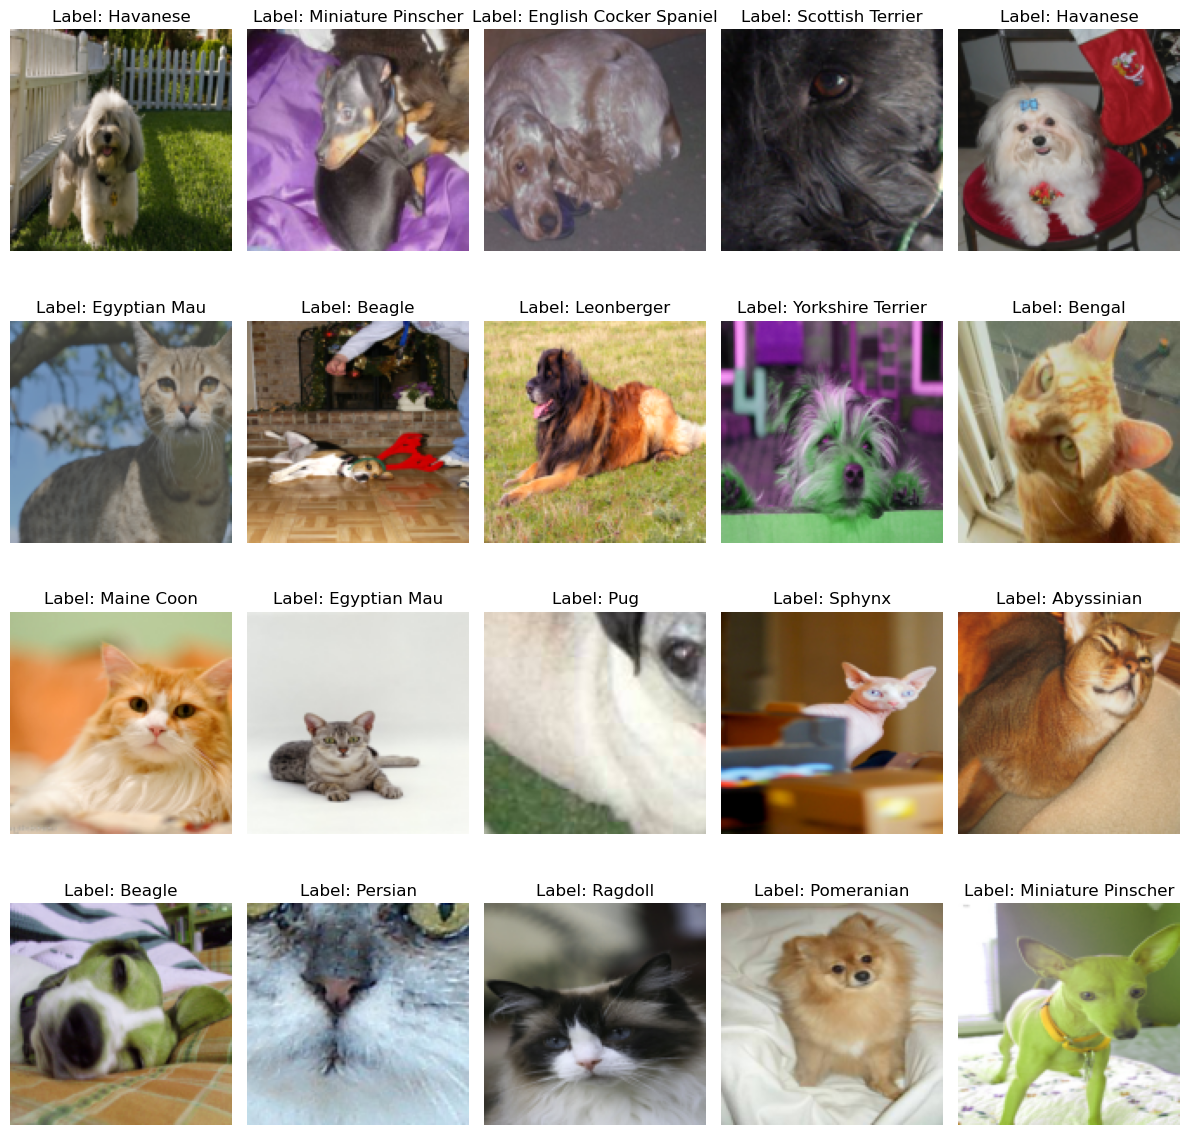

In [12]:
# Visualize 10 images from batch
fig, axs = plt.subplots(4, 5, figsize=(12, 12))
for i in range(20):
    image = batch[i]
    label = classes[i]
    image = image.numpy().transpose((1, 2, 0))
    image = std * image + mean
    image = np.clip(image, 0, 1)
    axs[i // 5, i % 5].imshow(image)
    axs[i // 5, i % 5].set_title(f"Label: {class_names[torch.argmax(label).item()]}")
    axs[i // 5, i % 5].axis('off')

plt.tight_layout()
plt.show()

## Training the model

Now, let\'s write a general function to train a model. Here, we will
illustrate:

-   Scheduling the learning rate
-   Saving the best model

In the following, parameter `scheduler` is an LR scheduler object from
`torch.optim.lr_scheduler`.


In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a directory to save training checkpoints
    best_model_params_path = './weights/alexnet_case8.pth'

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels.float())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == torch.argmax(labels,1))
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

## Visualizing the model predictions
Generic function to display predictions for a few images


In [14]:
def visualize_model(model, num_images=6, batch_num=0):
    was_training = model.training
    model.eval()

    with torch.no_grad():
        for batch_counter, (inputs, labels) in enumerate(dataloaders['val']):
            if batch_counter == batch_num:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                preds = torch.argmax(outputs, 1)
                labelsss = torch.argmax(labels, 1)

                fig, axs = plt.subplots(num_images//5, 5, figsize=(3*5, int(3*(num_images//5))))
                for ax in axs.flat:
                    ax.axis('off')

                for img_count in range(inputs.size()[0]):
                    # imshow(inputs.cpu().data[img_count])
                    inp = inputs.cpu().data[img_count]
                    inp = inp.numpy().transpose((1, 2, 0))
                    inp = std * inp + mean
                    inp = np.clip(inp, 0, 1)
                    axs[img_count//5, img_count%5].imshow(inp)
                    axs[img_count//5, img_count%5].set_title(f'predicted: {class_names[preds[img_count]]} \n true: {class_names[labelsss[img_count]]}') 

                    if img_count == num_images-1:
                        model.train(mode=was_training)
                        plt.tight_layout()
                        plt.show()
                        return

# Finetuning the ConvNet

In [15]:
model_conv = models.alexnet(weights='IMAGENET1K_V1')
# Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\ramay/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
model_conv

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [16]:
model_conv.classifier[6] = nn.Linear(4096, NUM_CLASSES)
model_conv.load_state_dict(torch.load('./weights/alexnet_case6.pth', weights_only=True))
model_ft = model_conv.to('cuda')

In [17]:
summary(model_conv, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE),verbose=0,
    col_names=["output_size", "num_params", "trainable"],
    row_settings=["var_names"],)

Layer (type (var_name))                  Output Shape              Param #                   Trainable
AlexNet (AlexNet)                        [256, 37]                 --                        True
├─Sequential (features)                  [256, 256, 3, 3]          --                        True
│    └─Conv2d (0)                        [256, 64, 31, 31]         23,296                    True
│    └─ReLU (1)                          [256, 64, 31, 31]         --                        --
│    └─MaxPool2d (2)                     [256, 64, 15, 15]         --                        --
│    └─Conv2d (3)                        [256, 192, 15, 15]        307,392                   True
│    └─ReLU (4)                          [256, 192, 15, 15]        --                        --
│    └─MaxPool2d (5)                     [256, 192, 7, 7]          --                        --
│    └─Conv2d (6)                        [256, 384, 7, 7]          663,936                   True
│    └─ReLU (7)        

## Train and evaluate

In [18]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_conv.parameters(), lr=0.0003, momentum=0.9)

# Decay LR by a factor of 0.5 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.5)

In [19]:
model_conv = train_model(model_conv, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.6992 Acc: 0.4921
val Loss: 1.2489 Acc: 0.6240

Epoch 1/24
----------
train Loss: 1.5173 Acc: 0.5373
val Loss: 1.1751 Acc: 0.6494

Epoch 2/24
----------
train Loss: 1.4020 Acc: 0.5700
val Loss: 1.1435 Acc: 0.6503

Epoch 3/24
----------
train Loss: 1.3306 Acc: 0.5875
val Loss: 1.1283 Acc: 0.6630

Epoch 4/24
----------
train Loss: 1.2704 Acc: 0.6046
val Loss: 1.0929 Acc: 0.6721

Epoch 5/24
----------
train Loss: 1.2118 Acc: 0.6211
val Loss: 1.1015 Acc: 0.6667

Epoch 6/24
----------
train Loss: 1.1656 Acc: 0.6359
val Loss: 1.0718 Acc: 0.6730

Epoch 7/24
----------
train Loss: 1.1187 Acc: 0.6481
val Loss: 1.0665 Acc: 0.6894

Epoch 8/24
----------
train Loss: 1.1023 Acc: 0.6559
val Loss: 1.0550 Acc: 0.6939

Epoch 9/24
----------
train Loss: 1.0771 Acc: 0.6594
val Loss: 1.0551 Acc: 0.6830

Epoch 10/24
----------
train Loss: 1.0623 Acc: 0.6648
val Loss: 1.0521 Acc: 0.6894

Epoch 11/24
----------
train Loss: 1.0418 Acc: 0.6716
val Loss: 1.0462 Acc: 0.6903

Ep

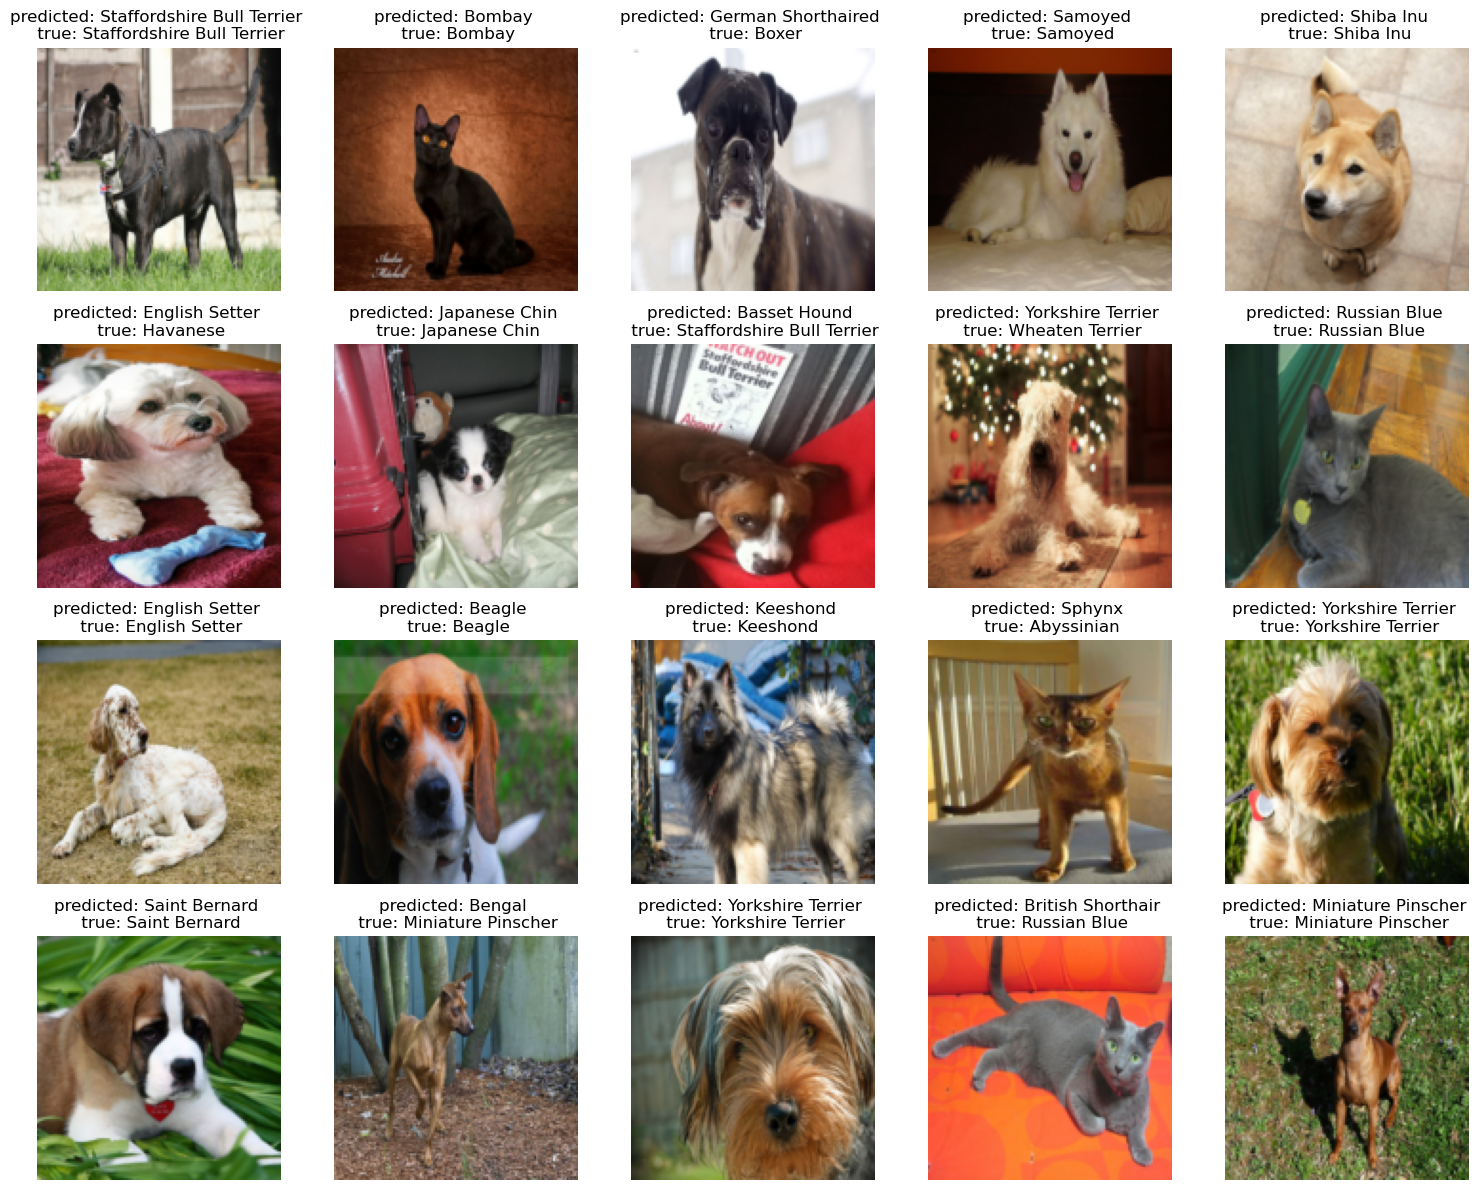

In [20]:
visualize_model(model_conv, num_images=20, batch_num=1)